In [5]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import sys, collections, os, argparse
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

In [96]:
# laod hg38 transcript to gene annotation map

tr2g = {}
trlist = []
g2n = {}
with open('./ref/t2g_kb.txt') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])
        g2n[l[1]] = l[2]

genes = list(set(tr2g[t] for t in tr2g))



# load equivalence classes
# equivalence classes: the Reads aligned to same(ambigiously)
# transcript are considered to be "close", which are generalized into
# the same equivalence class.
ecs = {}
with open('./count_out/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [4]:
# load kallisto bus output dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('./count_out/output_unfiltered.bus.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]

In [6]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s

## Check barcode-gene distribution

4703


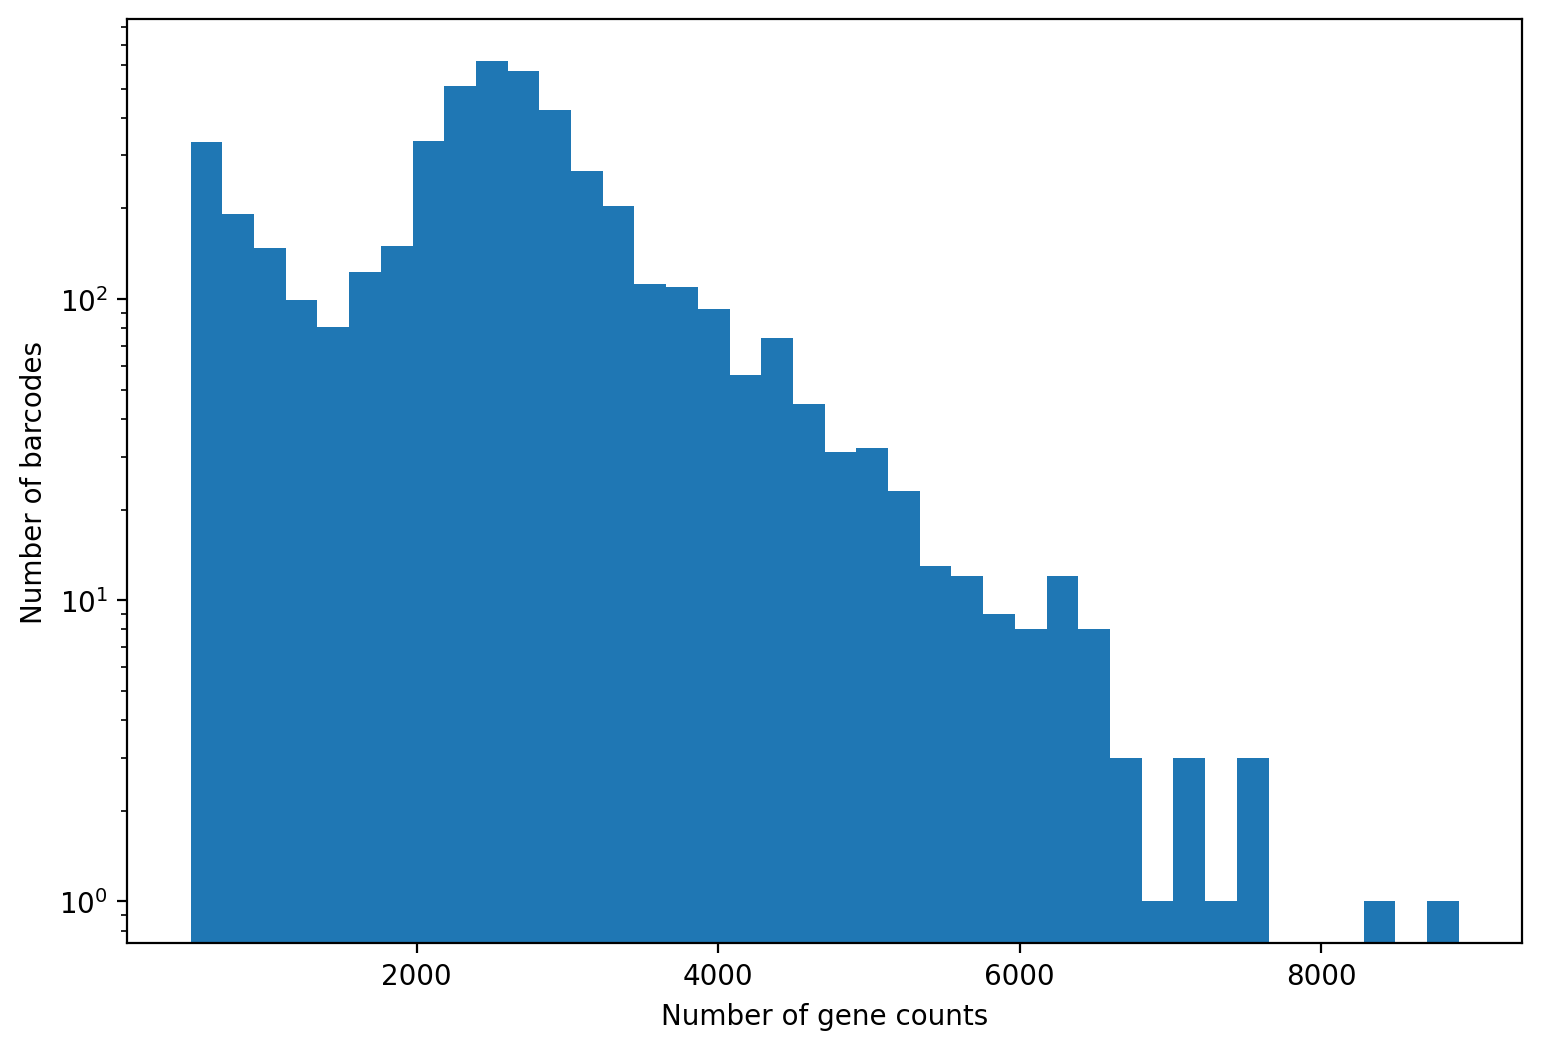

In [23]:
threshold = 0 # this filters the data by gene count
bcv = [x for b,x in barcode_hist.items() if x > 500 and x < 10000] 
_ = plt.hist(bcv,bins=40, log=True)
plt.rcParams["figure.figsize"] = [9,6]
plt.xlabel("Number of gene counts")
plt.ylabel("Number of barcodes")
print(len(bcv))

In [2]:
import scanpy as sc
import anndata
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from scipy import sparse, io

## Import cell-gene count matrix

In [120]:
adata = anndata.read("./count_out/counts_unfiltered/adata.h5ad")
adata

AnnData object with n_obs × n_vars = 147145 × 60623
    var: 'gene_name'

## Check PCA plot

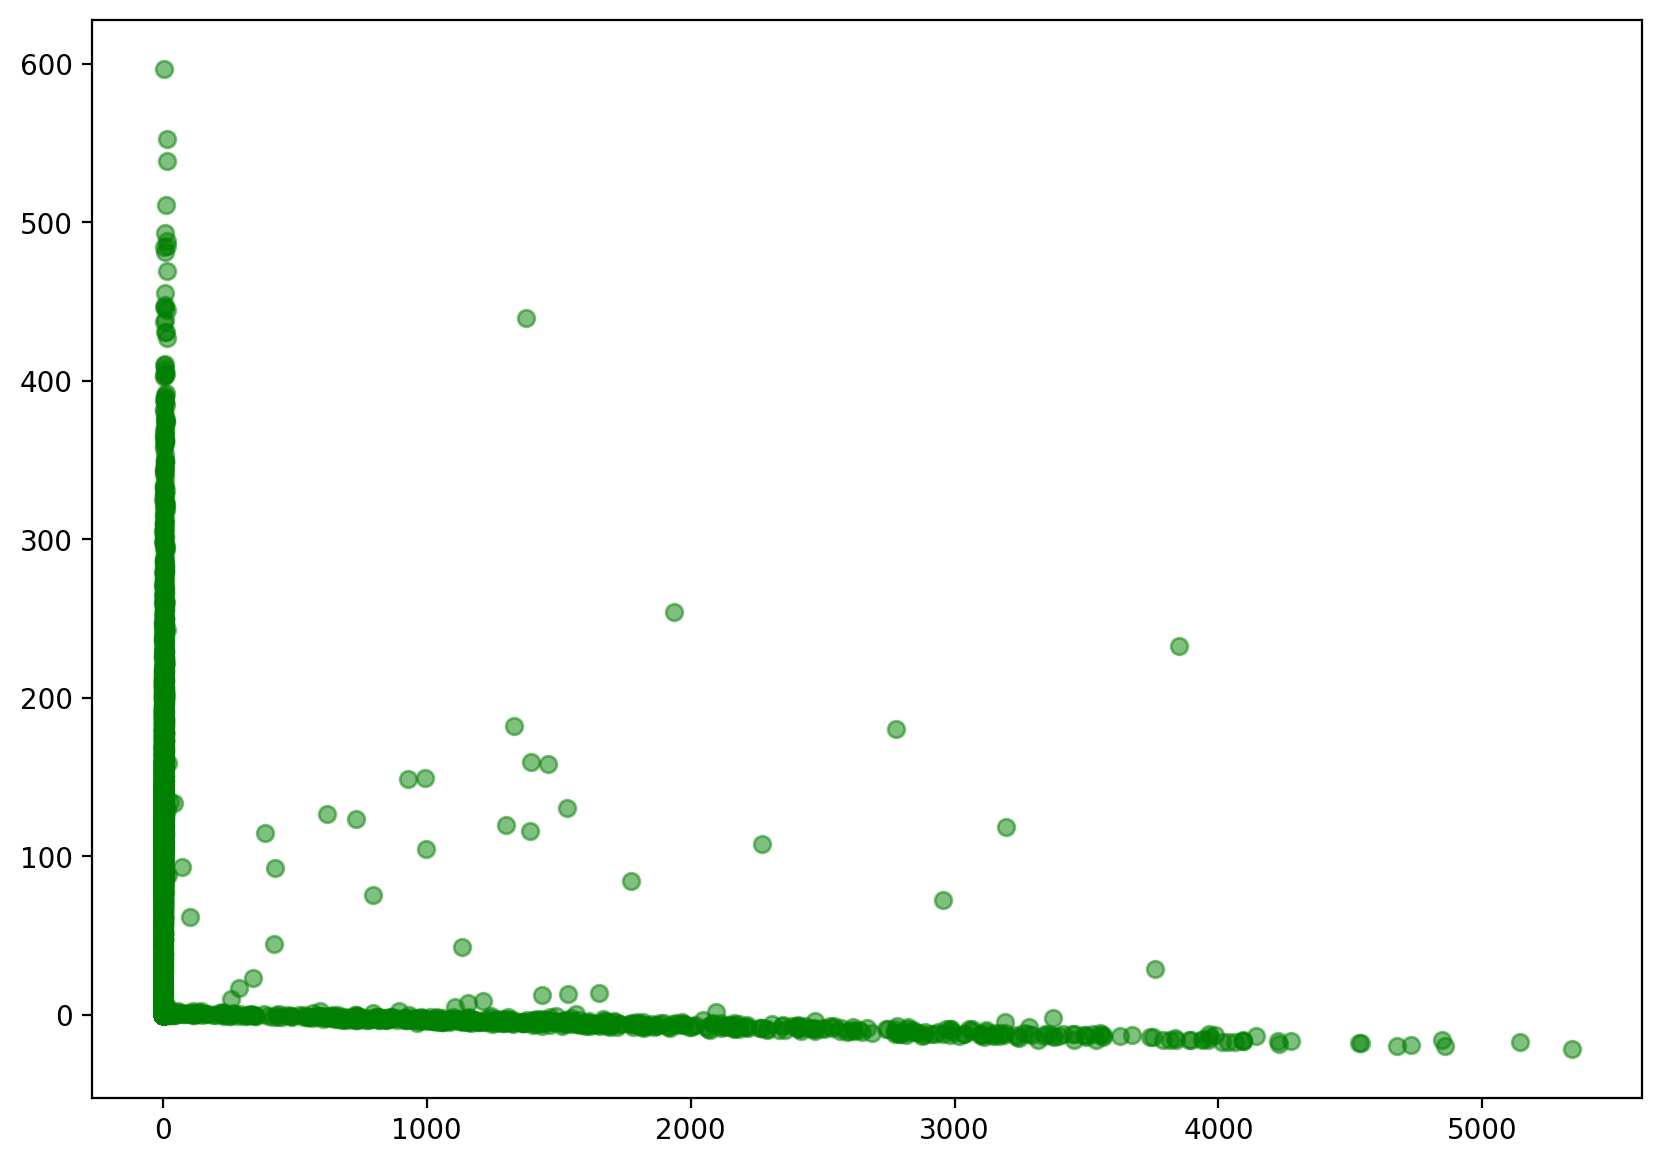

In [121]:
tsvd = TruncatedSVD(n_components=2)
tsvd.fit(adata.X)
X = tsvd.transform(adata.X)

# Plot the cells in the 2D PCA projection
fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(X[:,0], X[:,1], alpha=0.5, c="green")

plt.show()

## Library Satruation

TypeError: LogScale.__init__() got an unexpected keyword argument 'nonposy'

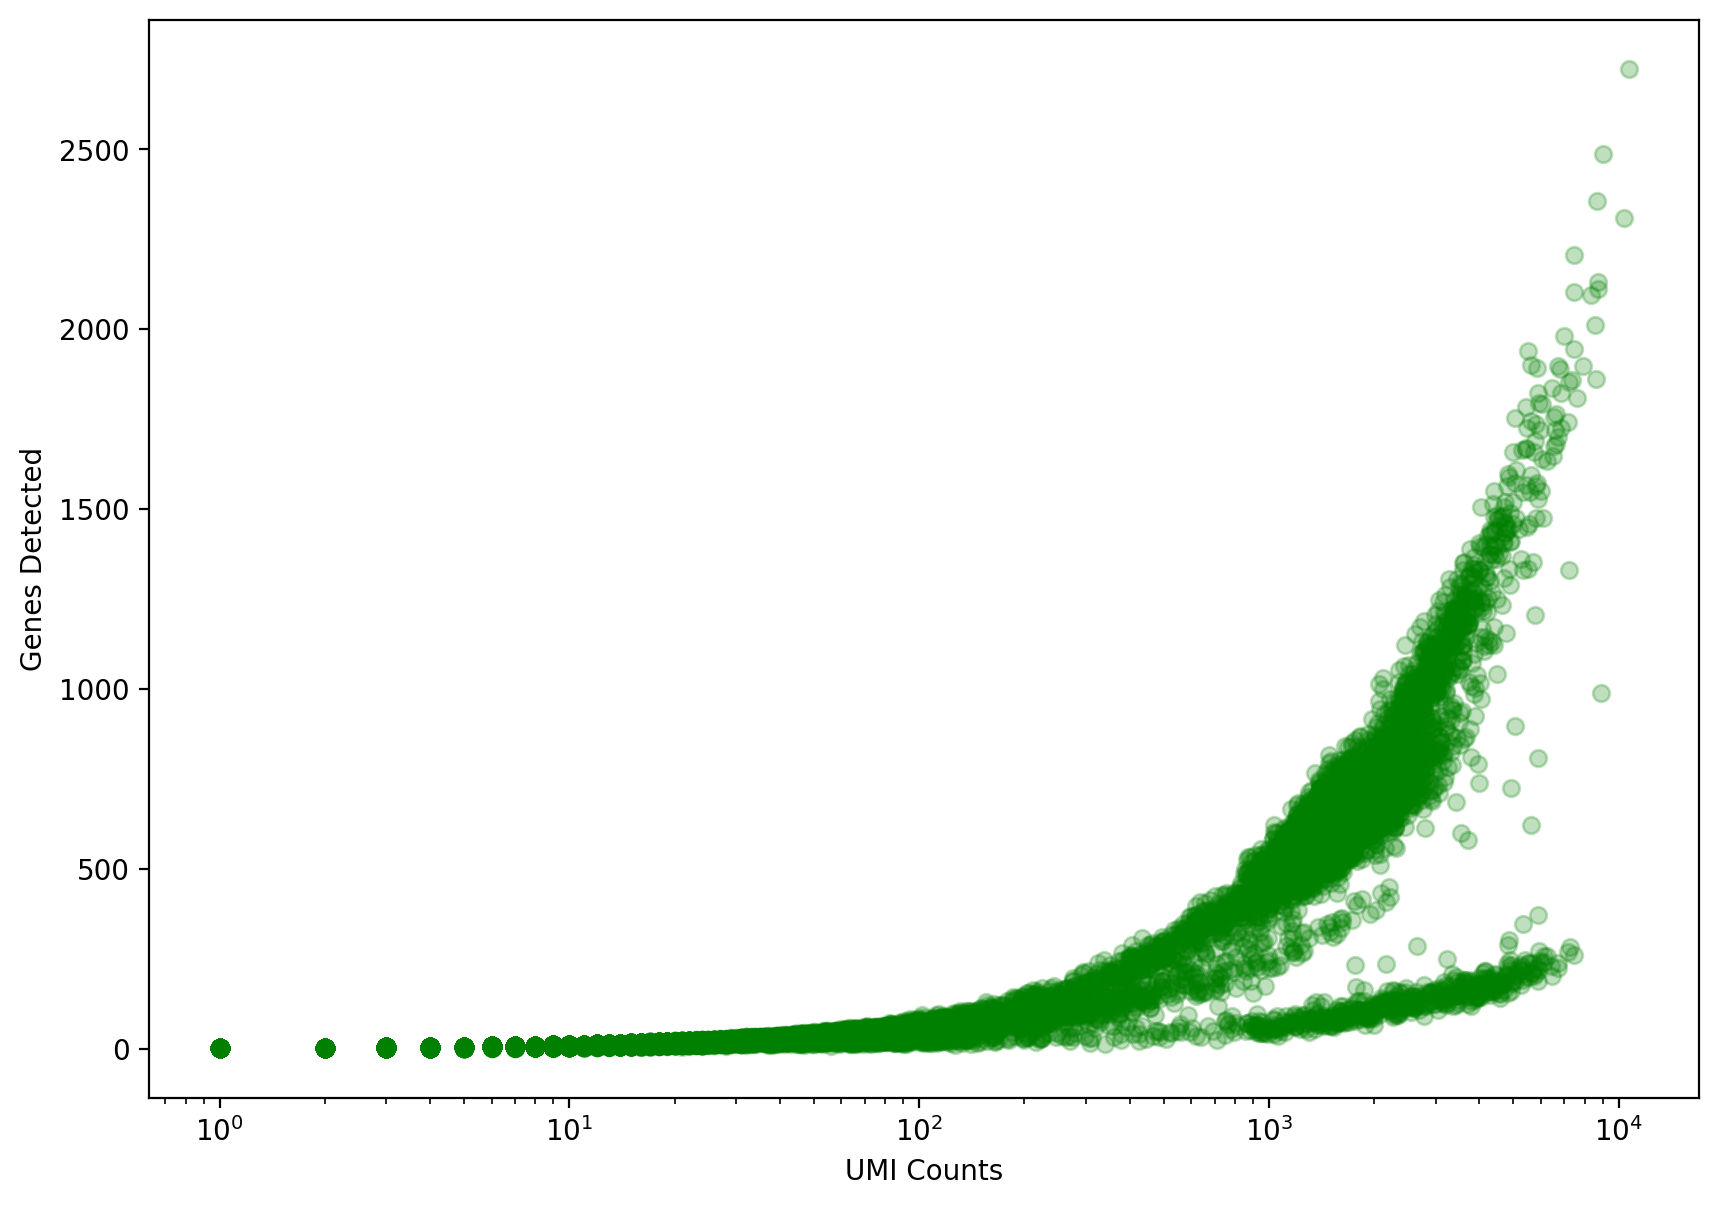

In [122]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(10, 7))

x = np.asarray(adata.X.sum(axis=1))[:,0]
y = np.asarray(np.sum(adata.X>0, axis=1))[:,0]

ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log', nonposy='clip')

ax.set_xlim((0.5, 4500))
ax.set_ylim((0.5,2000))


plt.show()

## Knee point

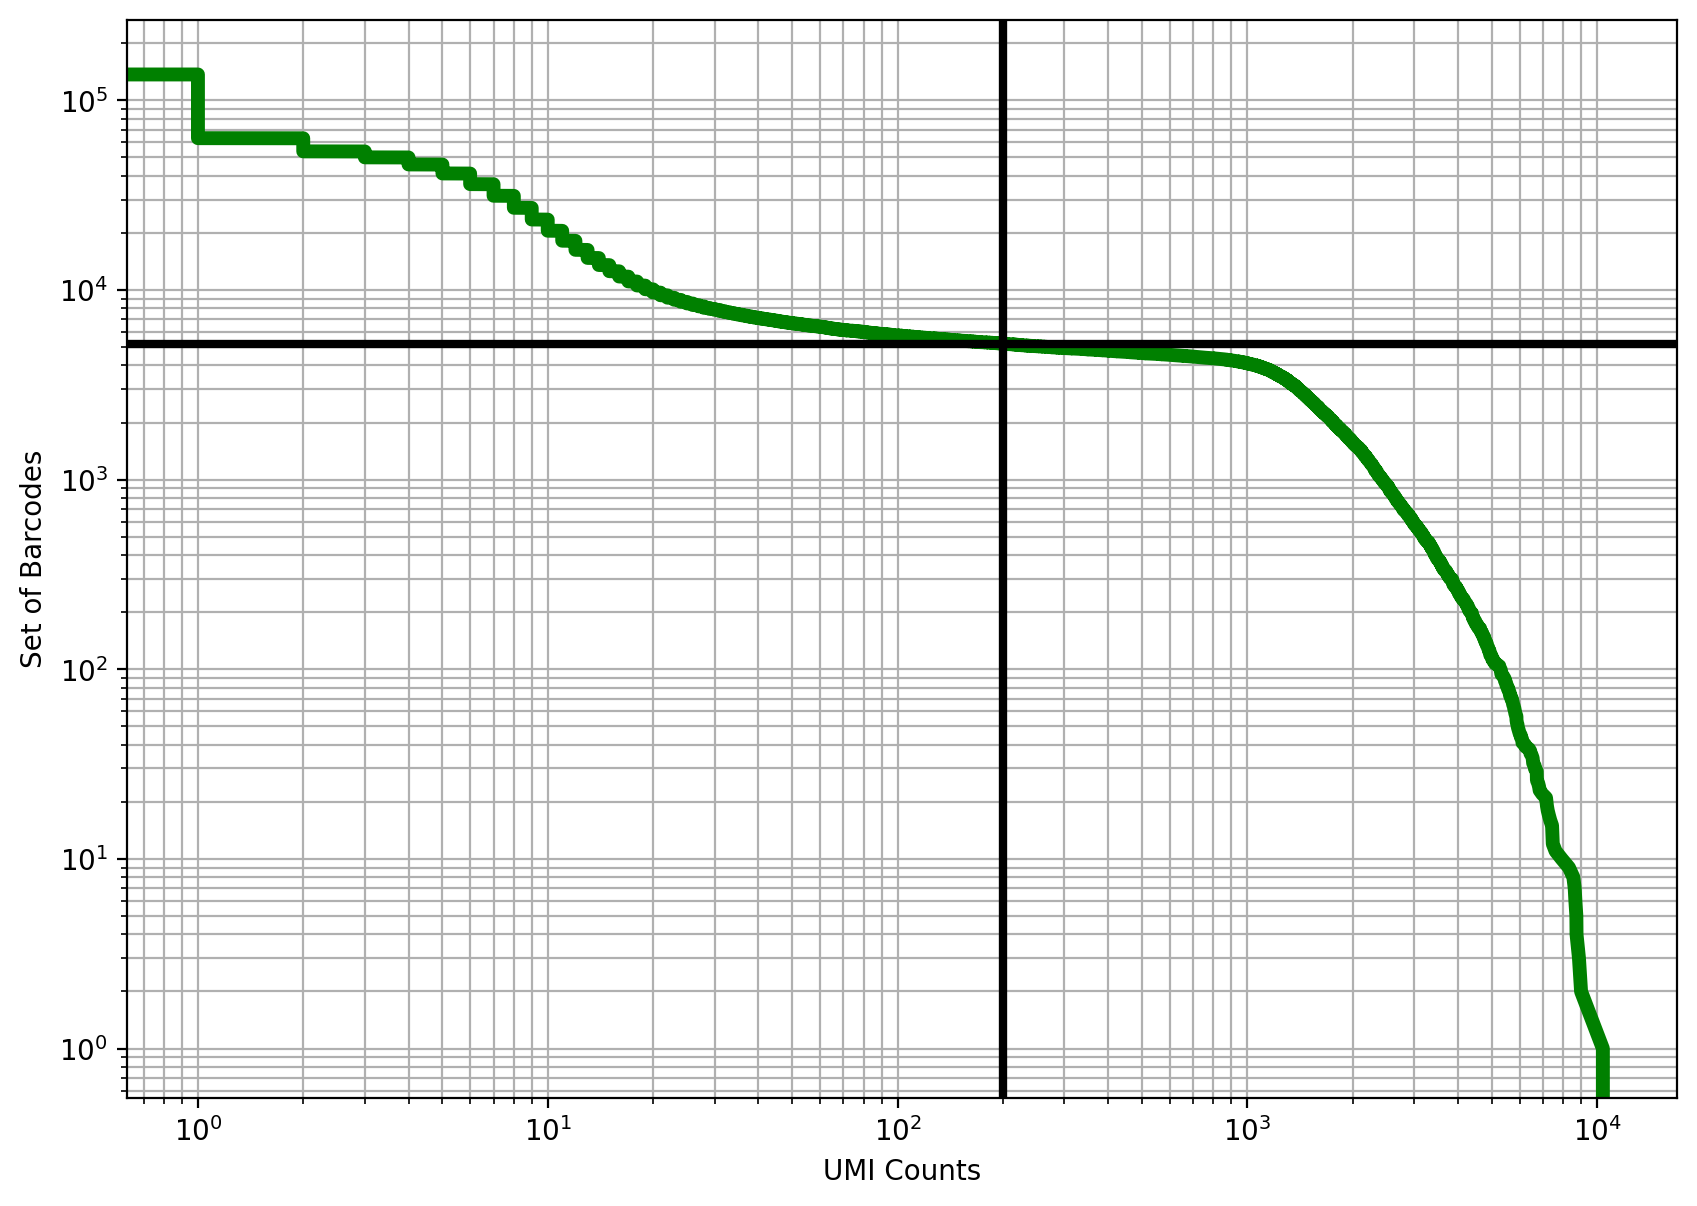

In [123]:
# { run: "auto", vertical-output: true }
cutoff =  200#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]
cell_set = np.arange(len(knee))
num_cells = cell_set[knee > cutoff][::-1][0]

fig, ax = plt.subplots(figsize=(10, 7))


ax.loglog(knee, cell_set, linewidth=5, color="g")
ax.axvline(x=cutoff, linewidth=3, color="k")


ax.axhline(y=num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()

In [124]:
print(f"{num_cells:,.0f} cells passed the {cutoff} UMI threshold")

5,206 cells passed the 200 UMI threshold


## Filter data

In [125]:
# empty droplets
adata

AnnData object with n_obs × n_vars = 147145 × 60623
    var: 'gene_name'

In [126]:
# Filter the cells according to the threshold determined from the knee plot
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=knee[num_cells])

In [127]:
adata

AnnData object with n_obs × n_vars = 4263 × 60623
    obs: 'n_genes', 'n_counts'
    var: 'gene_name'

## Visualizing count dist

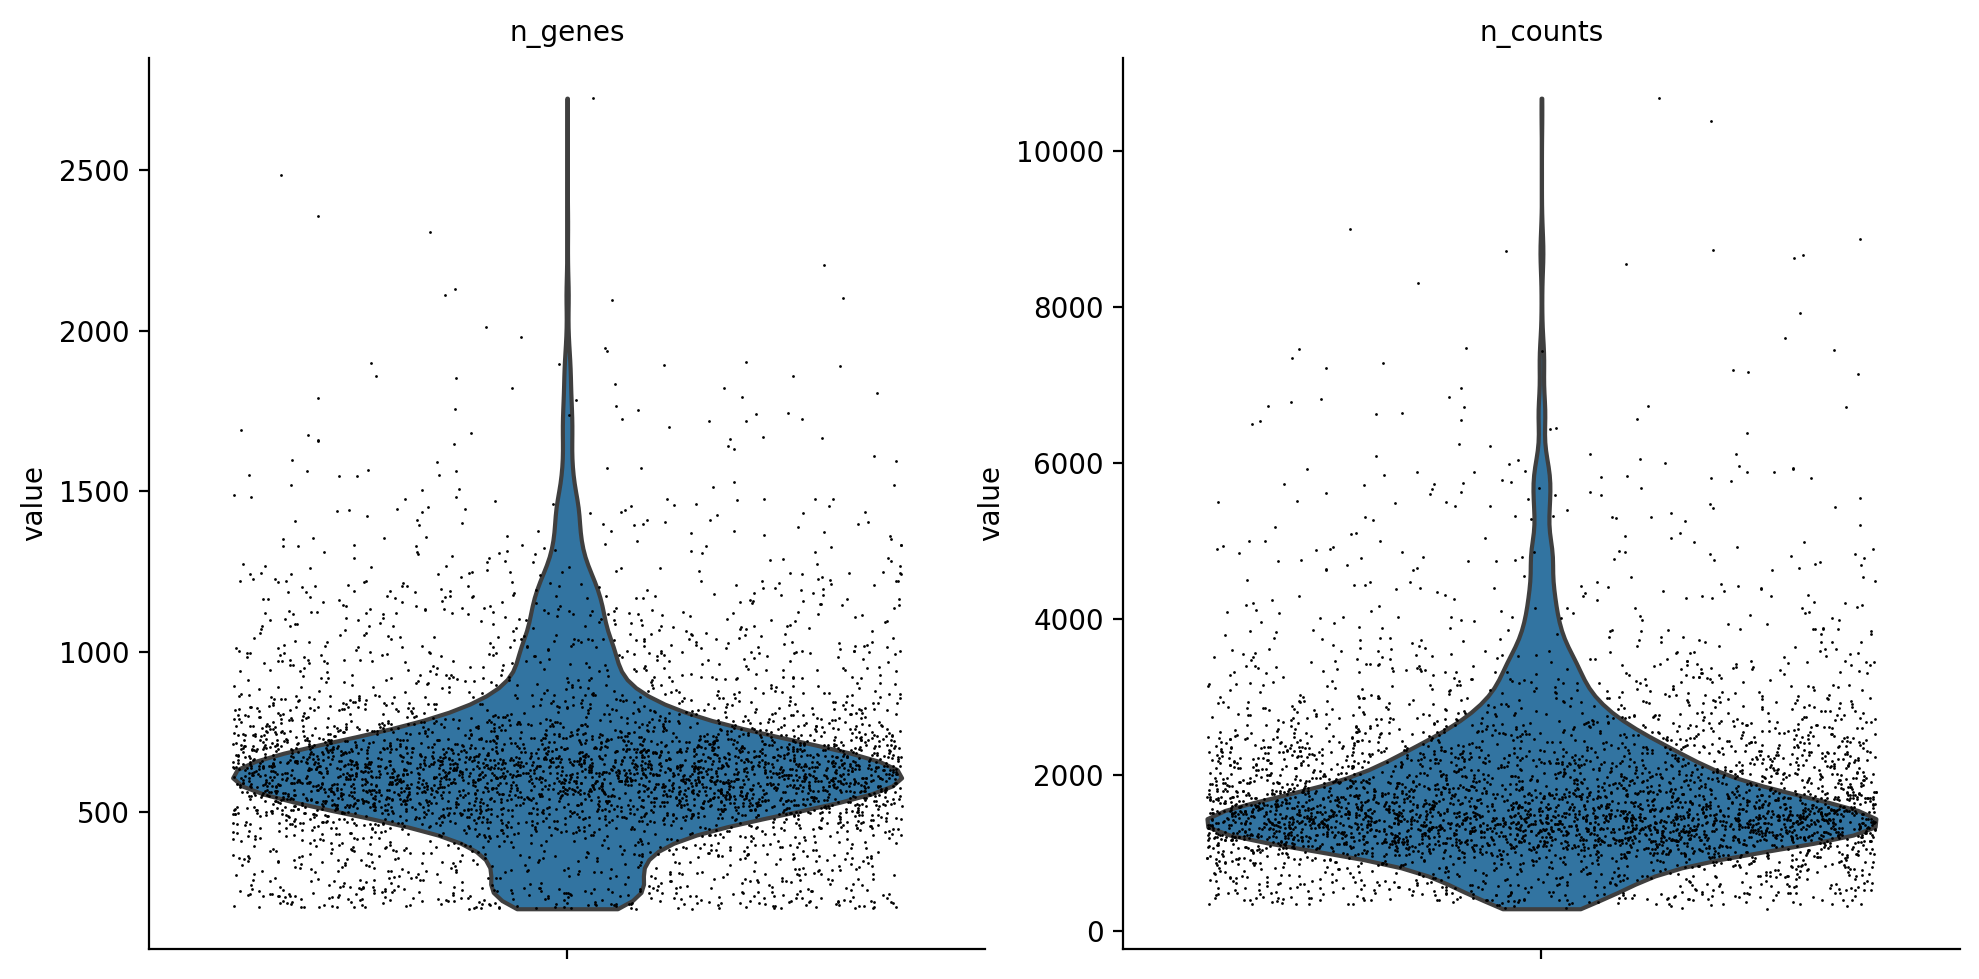

In [128]:
sc.pl.violin(adata, ['n_genes', 'n_counts'], jitter=0.4, multi_panel=True)

## Normalization

In [129]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

## Identify highly variable genes

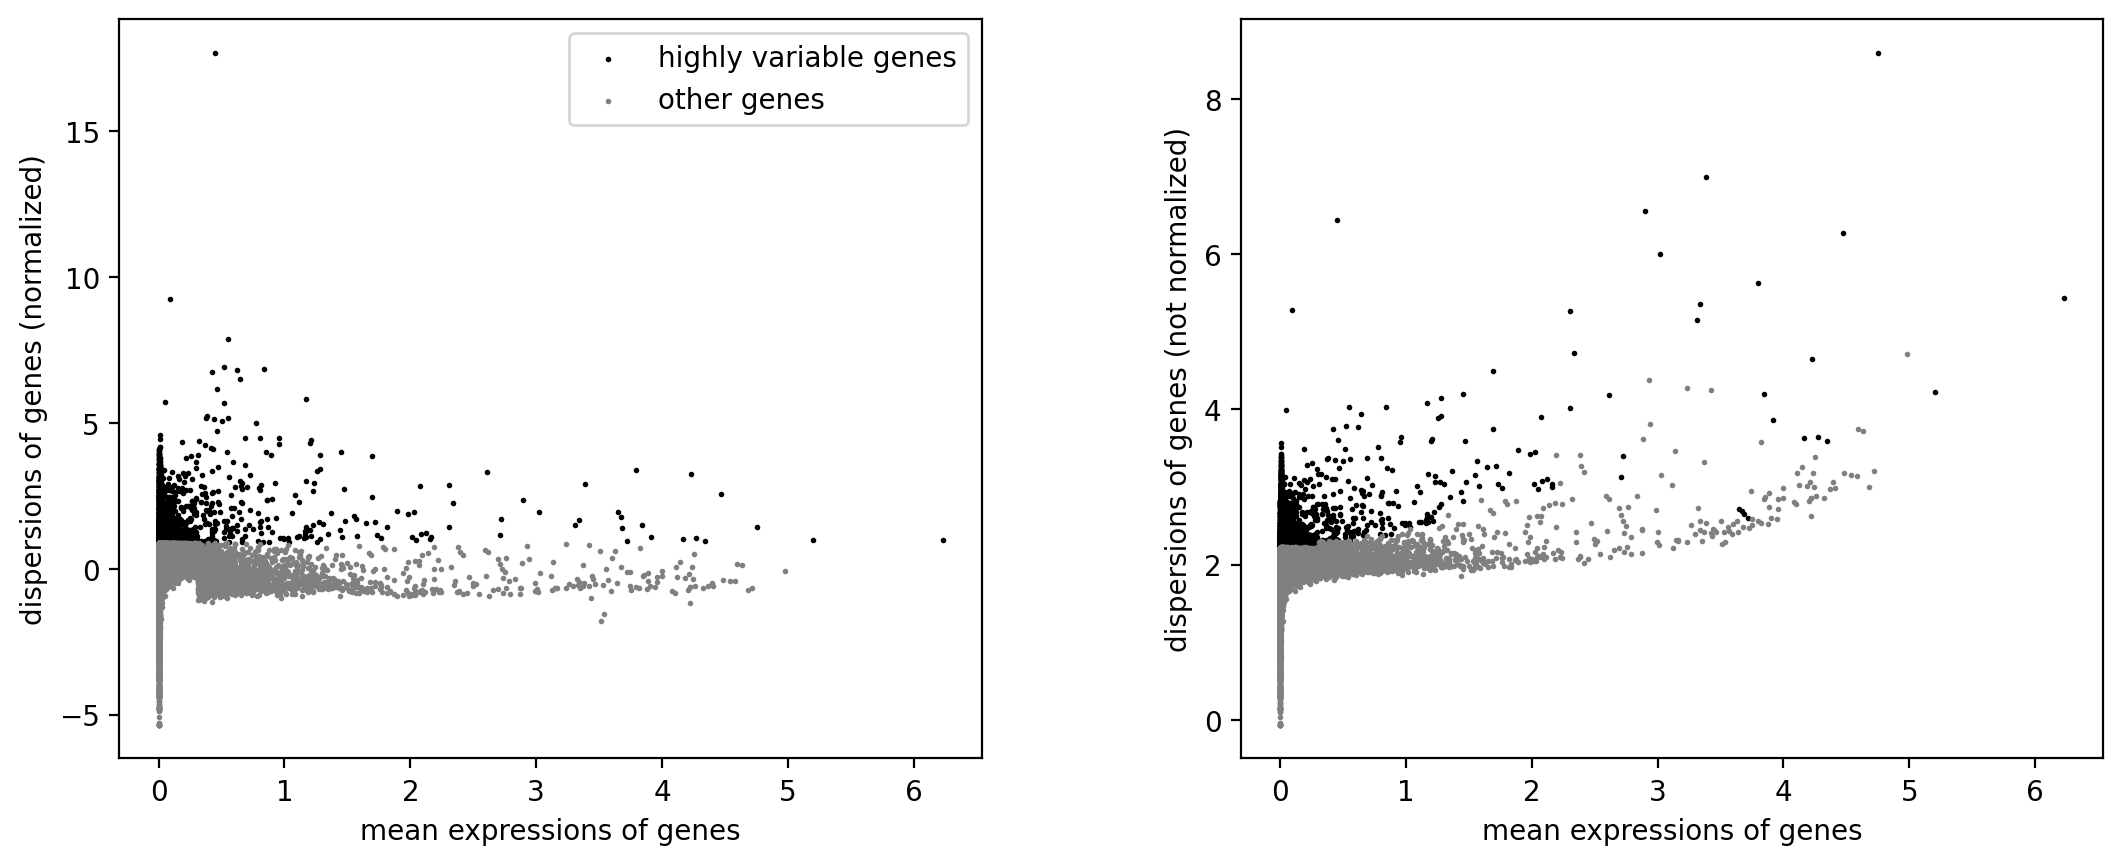

In [130]:
sc.pp.highly_variable_genes(adata, min_mean=0.01, max_mean=8, min_disp=1, n_top_genes=3000, n_bins=20, flavor="seurat")
sc.pl.highly_variable_genes(adata)

In [131]:
sc.pp.scale(adata, max_value=10)

## Clustering

In [159]:
adata.var


,gene_name,highly_variable,means,dispersions,dispersions_norm,mean,std
gene_id,,,,,,,
ENSG00000223972.5,DDX11L1,False,1.000000e-12,NaN,NaN,0.000000,1.000000
ENSG00000227232.5,WASH7P,False,1.000000e-12,NaN,NaN,0.000000,1.000000
ENSG00000278267.1,MIR6859-1,False,1.000000e-12,NaN,NaN,0.000000,1.000000
ENSG00000243485.5,MIR1302-2HG,False,1.000000e-12,NaN,NaN,0.000000,1.000000
ENSG00000284332.1,MIR1302-2,False,1.000000e-12,NaN,NaN,0.000000,1.000000
...,...,...,...,...,...,...,...
ENSG00000271254.6,AC240274.1,False,2.475695e-03,1.911048,0.047222,0.000811,0.038825
ENSG00000275405.1,U1,False,1.000000e-12,NaN,NaN,0.000000,1.000000
ENSG00000275987.1,U1,False,1.000000e-12,NaN,NaN,0.000000,1.000000


In [152]:
# Louvain clustering
# Cluster the cells using Louvain clustering
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True, n_comps=10)
sc.pp.neighbors(adata, n_neighbors=40,n_pcs=10, knn=True)
sc.tl.louvain(adata, resolution=0.6)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


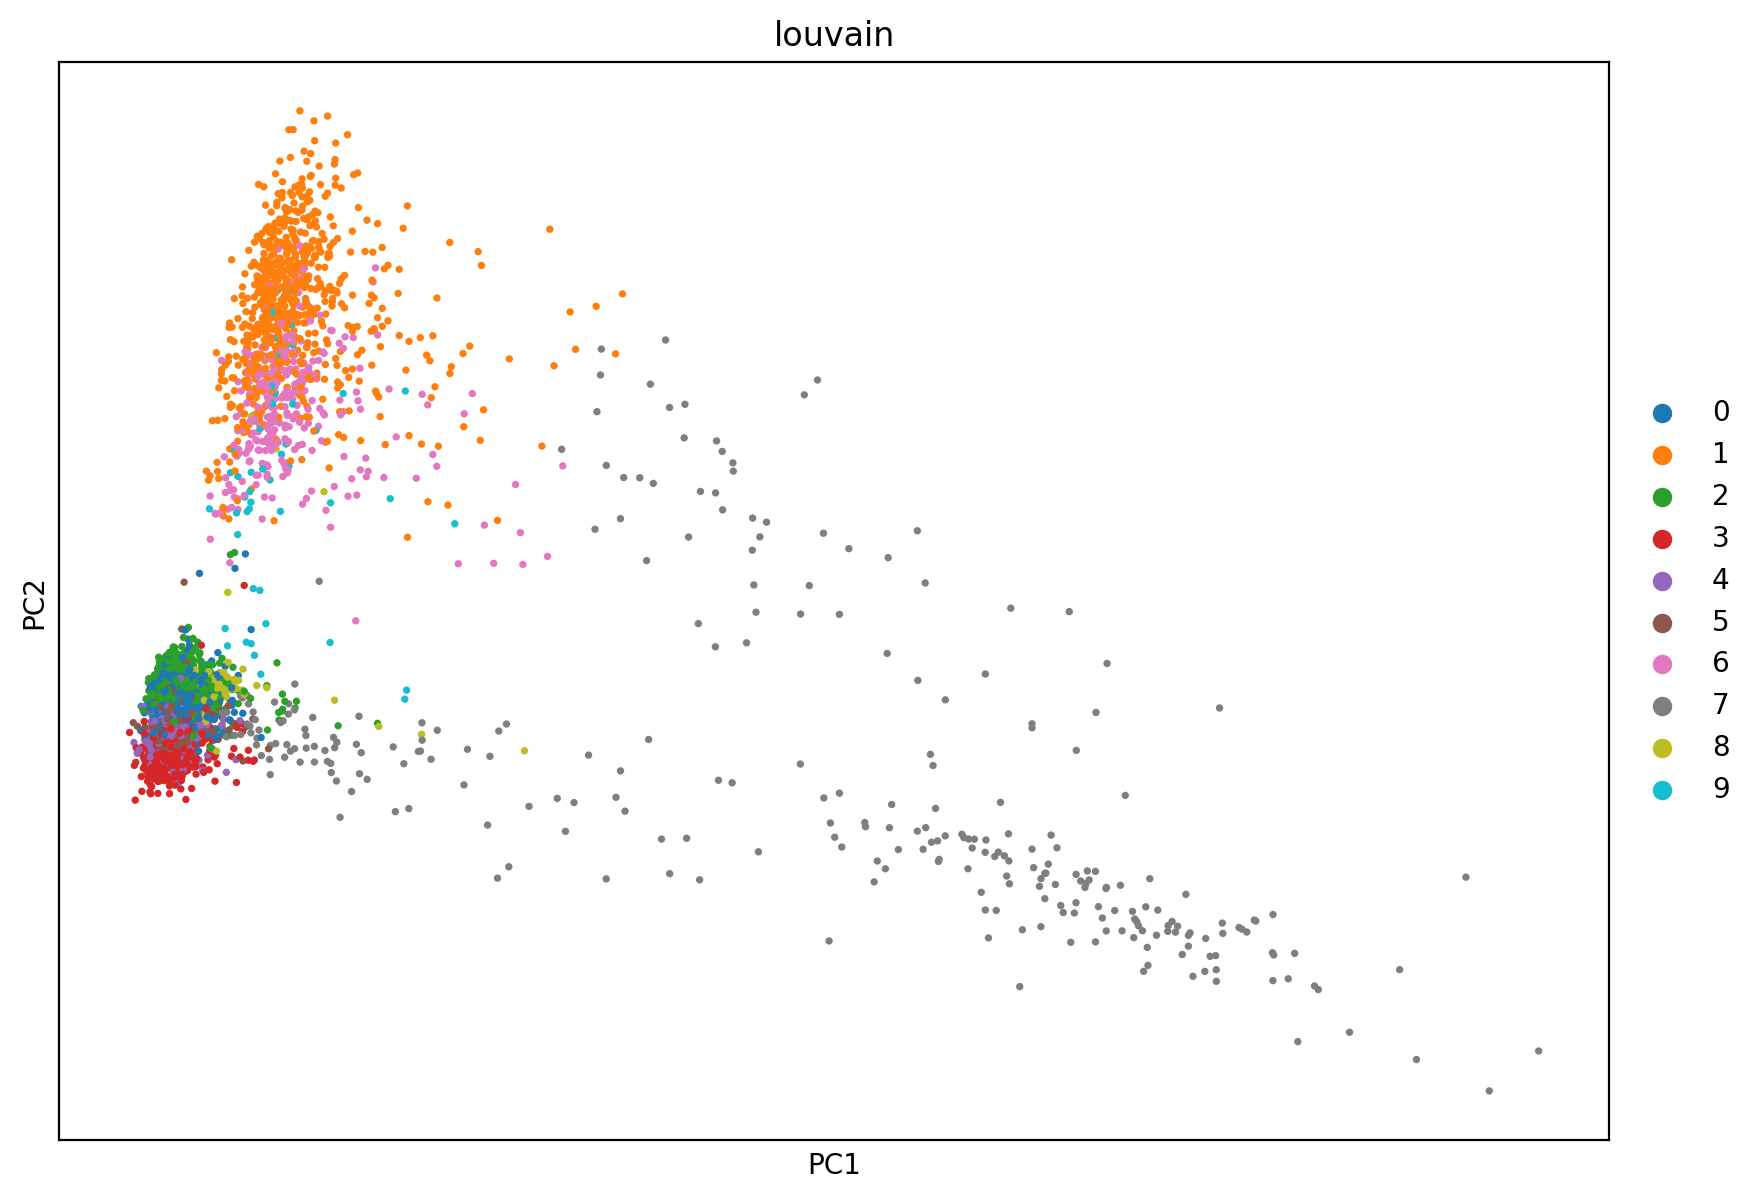

In [133]:
# Perform PCA and plot the projection to the first two dimensions, with points colored according to the Louvain clusters.
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.pca(adata, color='louvain', ax=ax)

In [134]:
# t-SNE /w top 10 pcs
# performing t-SNE
sc.tl.tsne(adata, n_pcs=10)

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


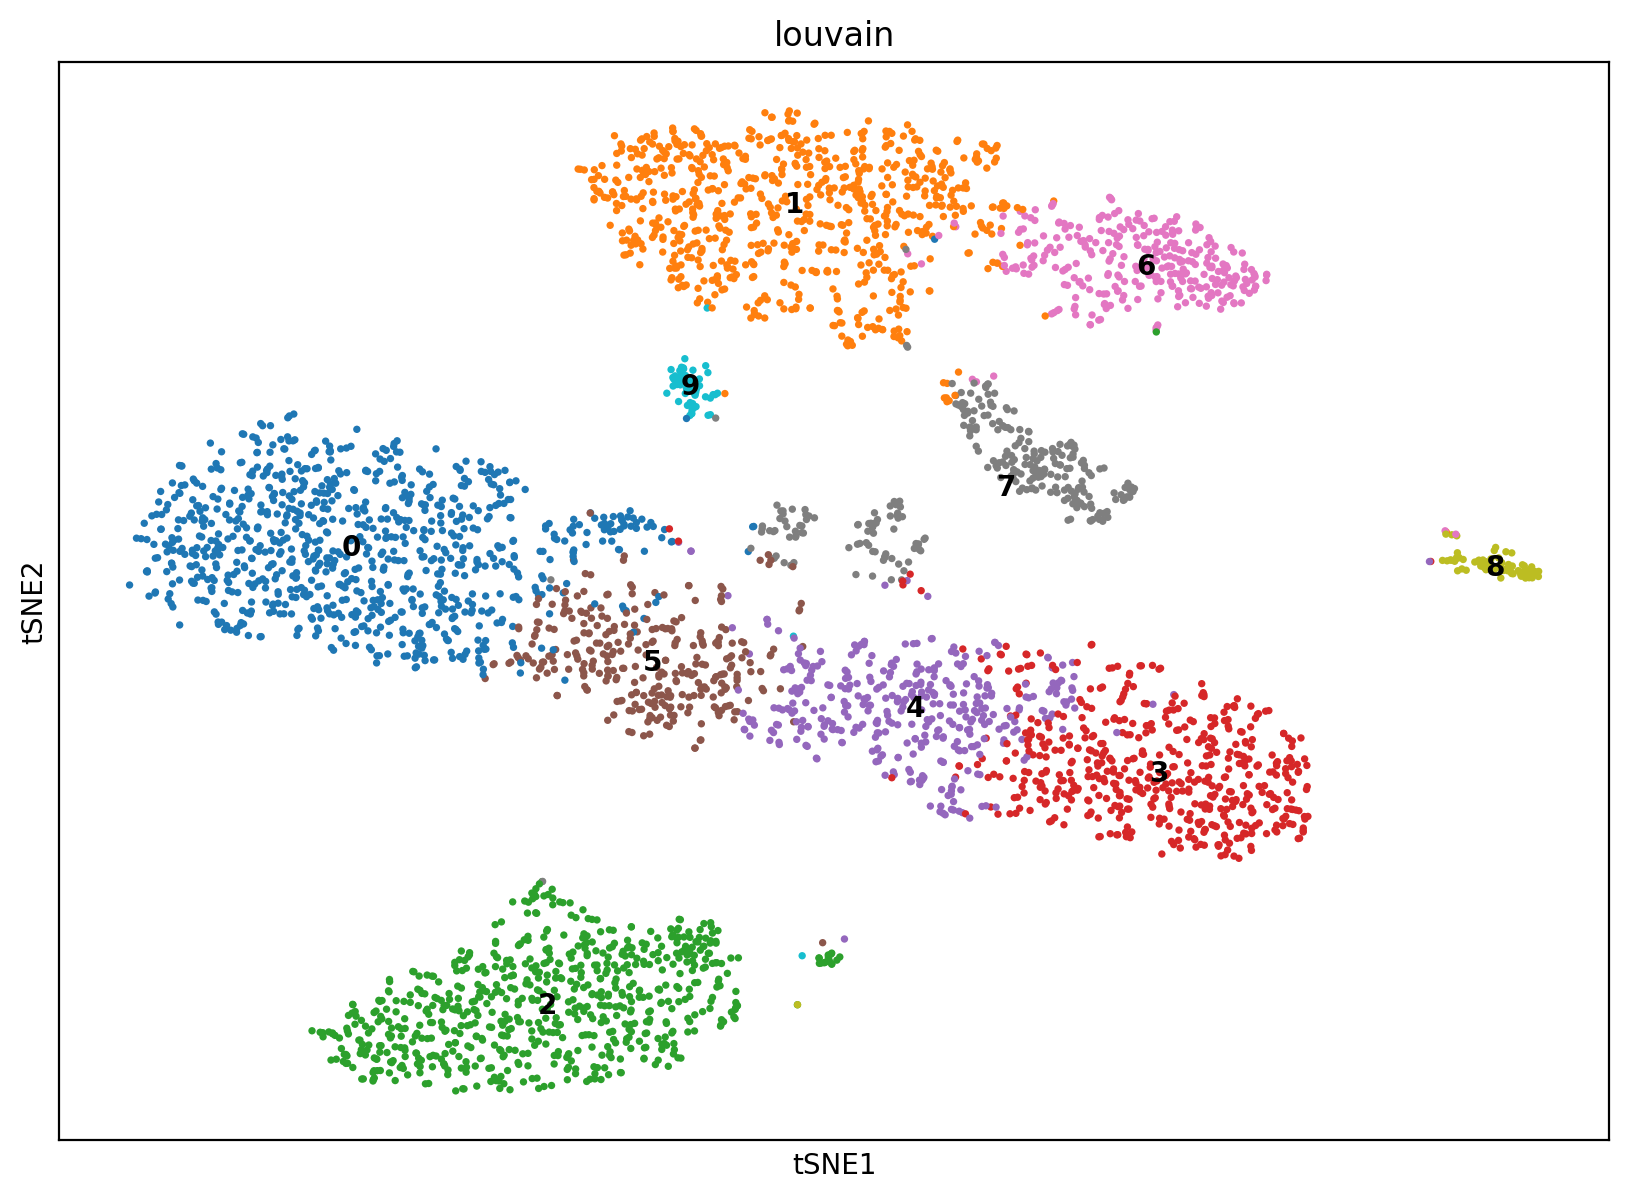

In [135]:
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.tsne(adata, color='louvain', ax=ax, gene_symbols='gene_name', use_raw=False, legend_loc='on data', save='.pdf')

/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/Users/liu.yak/anaconda3/envs/bioinfo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2

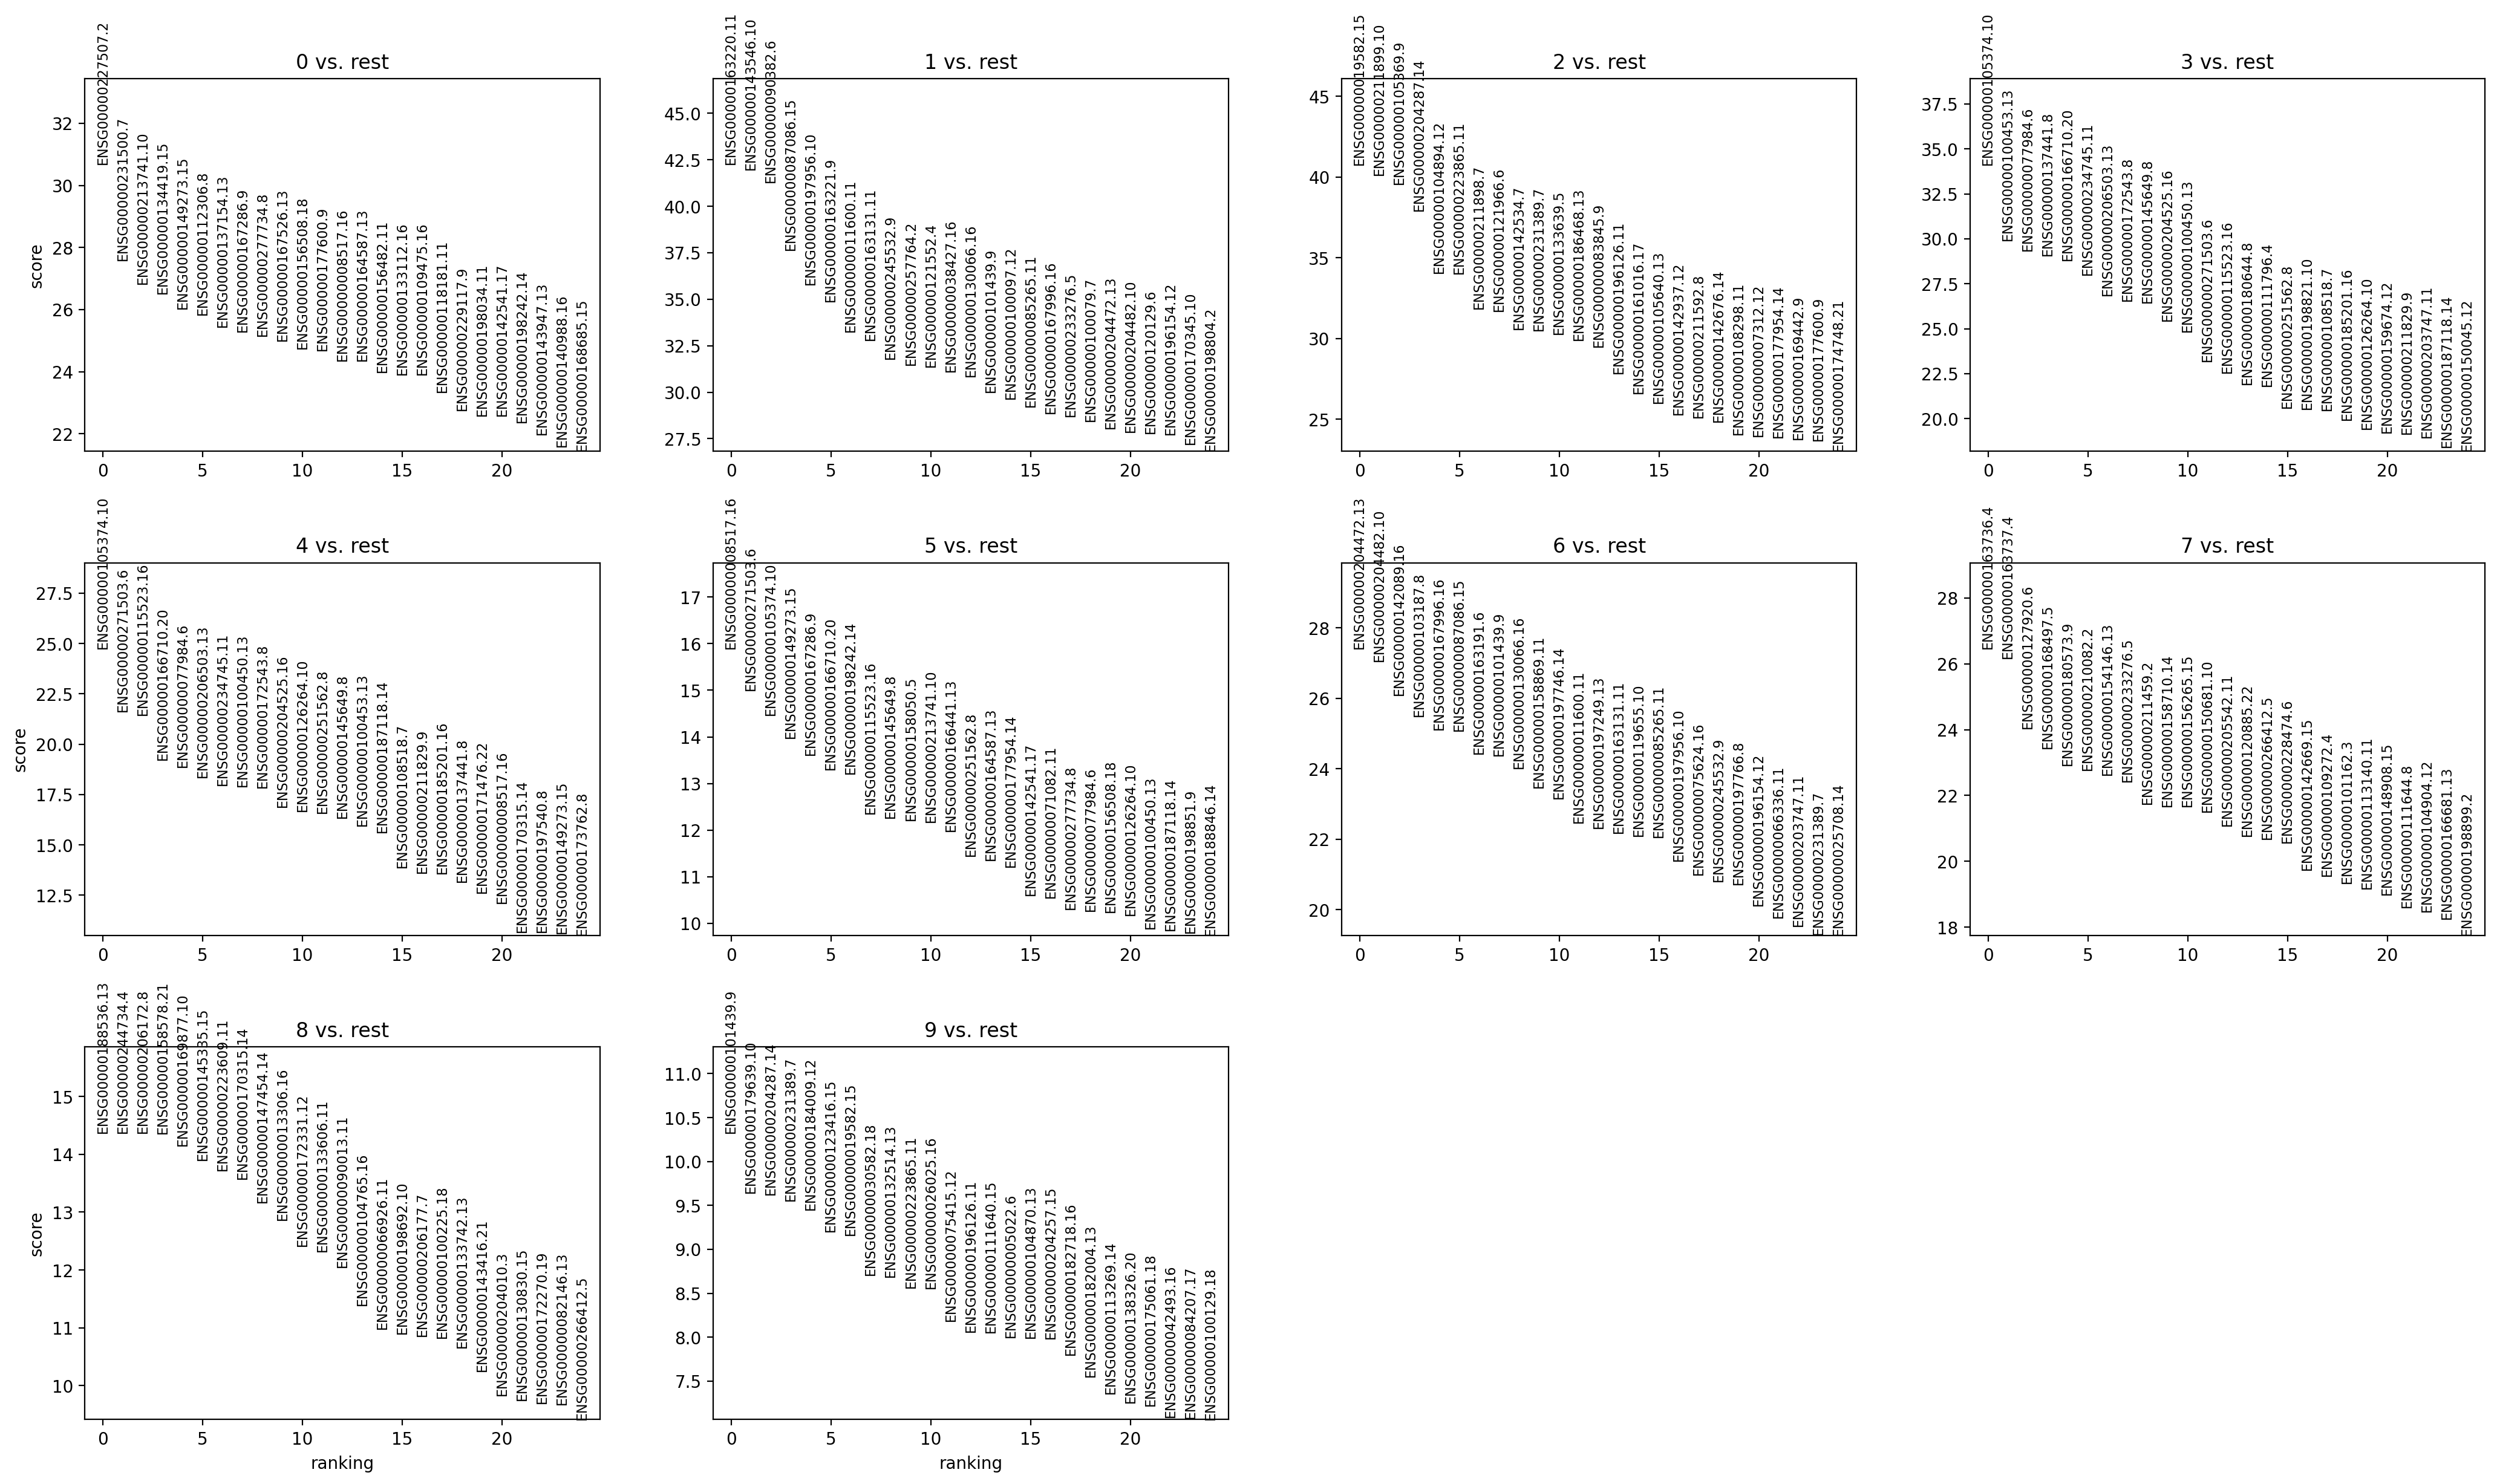

In [136]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [147]:
tmp = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
tmp = tmp.applymap(lambda x: x.replace(x, g2n[x]))
tmp

,0,1,2,3,4,5,6,7,8,9
0,LTB,S100A9,CD74,NKG7,NKG7,IL32,AIF1,PPBP,HBA2,CST3
1,RPS18,S100A8,IGHM,GZMB,CCL5,CCL5,LST1,PF4,HBB,FCER1A
2,RPS29,LYZ,CD79A,CST7,GNLY,NKG7,IFITM3,GNG11,HBA1,HLA-DRA
3,RPS15A,FTL,HLA-DRA,FGFBP2,B2M,RPS3,COTL1,CAVIN2,ALAS2,HLA-DPA1
4,RPS3,S100A6,CD37,B2M,CST7,CD3D,FTH1,HIST1H2AC,AHSP,ACTG1


In [157]:
cluster_markers = {
    'CD4 T': {'IL7R'},
    'CD14+\nMonocytes': {'CD14', 'LYZ'},
    'B': {'MS4A1'},
    'CD8 T': {'CD8A'},
    'NK': {'GNLY', 'NKG7'},
    'FCGR3A+\nMonocytes': {'FCGR3A', 'MS4A7'},
    'Dendritic': {'FCER1A', 'CST3'},
    'Mega-\nkaryocytes': {'PPBP'},
}
marker_matches = sc.tl.marker_gene_overlap(adata, cluster_markers)
marker_matches

,0,1,2,3,4,5,6,7,8,9
CD4 T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD14+\nMonocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CD8 T,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FCGR3A+\nMonocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dendritic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mega-\nkaryocytes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
